In [52]:
from PIL import Image
from IPython.display import display
from tqdm import tqdm

In [53]:
HALF_S = 4

In [54]:
def integral_img_matrix(img: Image.Image):
    w = img.size[0]
    h = img.size[1]

    i_img_m = [[0 for _ in range(w)] for _ in range(h)]

    for x in range(w):
        for y in range(h):
            p = img.getpixel((x, y))
            if x == 0 and y == 0:
                new_p = p
            elif x == 0 and y > 0:
                new_p = p + i_img_m[y - 1][x]
            elif x > 0 and y == 0:
                new_p = p + i_img_m[y][x - 1]
            else:
                new_p = p - i_img_m[y - 1][x - 1] + i_img_m[y - 1][x] + i_img_m[y][x - 1]
            i_img_m[y][x] = new_p
    return i_img_m

In [55]:
def semitone_photoshop_edition(img: Image.Image):
    if img.mode == 'L':
        return img

    w = img.size[0]
    h = img.size[1]

    new_img = Image.new('L', (w, h))
    for x in tqdm(range(w)):
        for y in range(h):
            p = img.getpixel((x, y))
            new_img.putpixel((x, y), int(0.3 * p[0] + 0.59 * p[1] + 0.11 * p[2]))
    return new_img

In [56]:
def binary_img(img: Image.Image, t):
    if str(img.mode) == "1":
        return img

    img = semitone_photoshop_edition(img)
    i_img_m = integral_img_matrix(img)
    w = img.size[0]
    h = img.size[1]
    new_img = Image.new("1", (w, h))

    for x in tqdm(range(w)):
        for y in range(h):
            p = img.getpixel((x, y))
            int_p = mid_pixel(i_img_m, x, y, w, h, HALF_S)
            if int_p == 0:
                new_img.putpixel((x, y), 1)
            elif p / int_p < 1 - t:
                new_img.putpixel((x, y), 0)
            else:
                new_img.putpixel((x, y), 1)
    return new_img

In [57]:
def mid_pixel(i_img_m, x, y, w, h, s):

    box_p_area = 0
    box_p_sum = 0

    if y + s >= h or x + s >= w:
        if y + s >= h and x + s >= w:
            x = w - 1
            y = h - 1
            box_p_sum = (
                    i_img_m[y][x]
                    - i_img_m[y - s][x]
                    - i_img_m[y][x - s]
                    + i_img_m[y - s][x - s]
            )
            box_p_area = (x + 1 - (x - s)) * (y + 1 - (y - s))

        elif y <= s <= x and x + s >= w:
            box_p_sum = (
                    i_img_m[y + s][w - 1]
                    - i_img_m[y + s][x - s]
            )
            box_p_area = (w - 1 - (x - s)) * (y + s + 1)
        elif x <= s <= y and y + s >= h:
            box_p_sum = (
                    i_img_m[h - 1][x + s]
                    - i_img_m[y - s][x + s]
            )
            box_p_area = (x + s + 1) * (h - 1 - (y - s) + 1)

        elif y + s >= h:
            box_p_sum = (
                    i_img_m[h - 1][x + s]
                    - i_img_m[y - s][x + s]
                    - i_img_m[h - 1][x - s]
                    + i_img_m[y - s][x - s]
            )
            box_p_area = (x + s - (x - s)) * (h - 1 - (y - s) + 1)

        elif x + s >= w:
            box_p_sum = (
                    i_img_m[y + s][w - 1]
                    - i_img_m[y - s][w - 1]
                    - i_img_m[y + s][x - s]
                    + i_img_m[y - s][x - s]
            )
            box_p_area = (w - (x - s)) * (y + s - (y - s) + 1)
        return box_p_sum // box_p_area

    box_p_sum = i_img_m[y + s][x + s]
    if x > s and y > s:
        box_p_sum = (
                box_p_sum
                - i_img_m[y - s][x + s]
                - i_img_m[y + s][x - s]
                + i_img_m[y - s][x - s]
        )
        box_p_area = (s * 2 + 1) ** 2

    elif y <= s <= x:
        box_p_sum -= i_img_m[y + s][x - s]
        box_p_area = (x + s - (x - s) + 1) * (y + s + 1)
    elif x <= s <= y:
        box_p_sum -= i_img_m[y - s][x + s]
        box_p_area = (x + s + 1) * (y + s - (y - s) + 1)

    elif x < s and y < s:
        box_p_sum = i_img_m[y][x]
        box_p_area = (x + 1) * (y + 1)
    return box_p_sum // box_p_area

In [58]:
img_path = './images/xmpl.bmp'

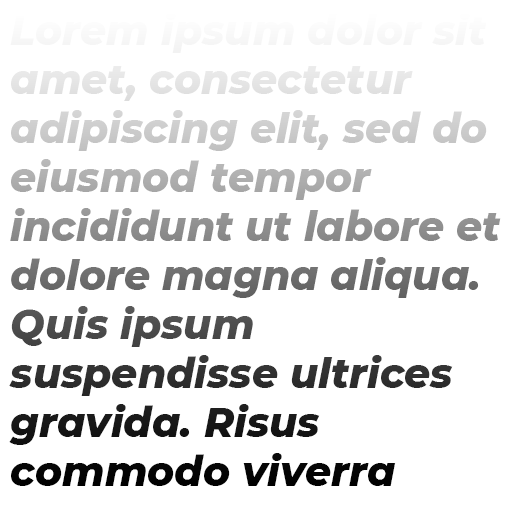

In [59]:
my_img = Image.open(img_path).convert('RGB')
display(my_img)

In [60]:
binary_image = binary_img(my_img, 0.05)
binary_image.save('./output_images/binary_xmpl.bmp')

100%|██████████| 512/512 [00:00<00:00, 624.52it/s]
